## Result 5: MOD markers in scRNA-seq data
Investigated the expression of MOD markers in both ST and scRNA-seq data:  
- in mature oligodendrocytes  
- in non-oligodendrocytes  

to assess 
- whether their expression patterns in scRNA-seq are consistent with those observed in ST data  
- whether these markers are also expressed in other cell types  

In [71]:
from pathlib import Path

import sys
import os
sys.path.append(os.path.abspath("../src"))

import importlib
import utils
import plot

importlib.reload(utils)
importlib.reload(plot)

from utils import load_merfish_signal_df, load_banksy_result, load_merfish_data, load_scRNA_data
from plot import plot_annotate_heatmap, CM, SAVE_FIG

import pandas as pd
import matplotlib.pyplot as plt

In [72]:
fig_path = Path("../data/results/R5")

### data

#### Signals in the Tissue Section

In [3]:
MERFISH_data_folder_path = Path("../data/mouse_hypothalamus/MERFISH/")

In [4]:
signal_coordinate_df, coordinate_x_m, coordinate_y_m = load_merfish_signal_df(MERFISH_data_folder_path/"merfish_barcodes_example.csv")

#### Results of BANKSY

In [5]:
banksy_folder_path = Path("../data/banksy_results/")

In [6]:
banksy_result = load_banksy_result(banksy_folder_path/"banksy_cluster.txt", coordinate_x_m, coordinate_y_m)

#### Segmentation Dataset

In [7]:
merfish_data = load_merfish_data(MERFISH_data_folder_path / "merfish_all_cells.csv", 
                                 banksy_result, coordinate_x_m, coordinate_y_m, 
                                 animal_id=1, bregma_value=-0.24)

#### Matched Single-Cell RNA Sequencing

In [8]:
data_path = Path("../data/mouse_hypothalamus/SingleCell/")
mtx_path = data_path / "GSE113576_matrix.mtx"
barcodes_path = data_path / "GSE113576_barcodes.tsv"
genes_path = data_path / "GSE113576_genes.tsv"
meta_path = data_path / "aau5324_Moffitt_Table-S1.xlsx"

In [9]:
cell_class_dict = {
    'Astrocytes': 'Astrocytes',
    'Microglia': 'Microglia',
    'Macrophage': 'Macrophage',
    'Excitatory': 'Excitatory',
    'Inhibitory': 'Inhibitory',
    'Immature oligodendrocyte': 'OD immature',
    'Newly formed oligodendrocyte': 'OD newly formed',
    'Mature oligodendrocyte': 'OD mature',
    'Ependymal': 'Ependymal',
    'Endothelial': 'Endothelial',
    'Mural': 'Mural',
    'Fibroblast': 'Fibroblast',
}

adata = load_scRNA_data(
    mtx_path, 
    barcodes_path, 
    genes_path, 
    meta_path, 
    cell_class_filter = cell_class_dict
)

#### Marker Genes

differentially expressed genes identified by BANKSY

In [10]:
# all differentially expressed genes
DE_genes = ['Mbp', 'Lpar1', 'Trh', 'Ucn3', 'Cck', 'Mlc1', 'Dgkk', 'Cbln2', 'Syt4', 'Gad1', 'Plin3', 'Gnrh1', 'Sln', 'Gjc3']
# DE_genes_MOD_gm: 7
DE_genes_MOD_gm = ['Mlc1', 'Dgkk', 'Cbln2', 'Syt4', 'Gad1', 'Plin3', 'Gnrh1', 'Sln', 'Gjc3']
# DE_genes_MOD_wm: 8
DE_genes_MOD_wm = ['Mbp', 'Lpar1', 'Trh', 'Ucn3', 'Cck']

In [11]:
sc_data = adata.to_df()
sc_DE_MOD_gm_df = sc_data[DE_genes_MOD_gm]
sc_DE_MOD_wm_df = sc_data[DE_genes_MOD_wm]
sc_DE = pd.concat([sc_DE_MOD_wm_df, sc_DE_MOD_gm_df], axis=1)

sc_cell_class = adata.obs['Cell_class']

In [33]:
# MERFISH, MOD, Marker Genes
MOD_merfish = merfish_data[(merfish_data['banksy']==7) | (merfish_data['banksy']==8)]
MOD_merfish = MOD_merfish.sort_values(by='banksy')

common_genes = [gene for gene in DE_genes if gene in MOD_merfish.columns]
MOD_merfish_DE = MOD_merfish[common_genes].T

MOD_banksy = MOD_merfish['banksy']

In [13]:
Gene_Group = pd.DataFrame([0,0,0,0,0,1,1,1,1,1,1,1,1,1], columns=['cluster'])

### Heatmaps

#### scRNA-seq: Marker Genes in MOD

In [15]:
MOD_sc_data = pd.concat([sc_DE, sc_cell_class], axis=1)
MOD_sc_data = MOD_sc_data[MOD_sc_data['Cell_class'].str.startswith("OD mat")]

MOD_sc_cell_class = MOD_sc_data['Cell_class']
MOD_sc_data = MOD_sc_data.drop('Cell_class', axis=1)

In [34]:
MOD_banksy = MOD_banksy.replace({7: 'MOD_wm', 8: 'MOD_gm'})

In [16]:
box_specs = [
    {"x_offset": 500, "width": 350, "color": "green"},
    {"x_offset": 1350, "width": 250, "color": "orange"},
    {"x_offset": 2620, "width": 200, "color": "blue"},
    {"x_offset": 4800, "width": 1800, "color": "red"}
]

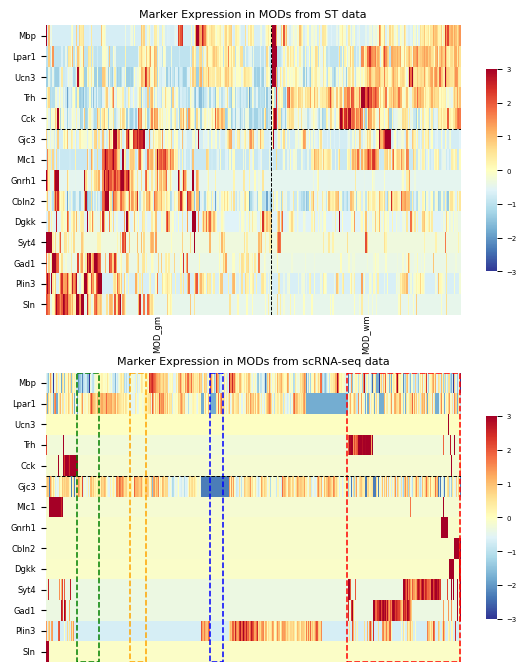

In [73]:
fig, ax = plt.subplots(2, 1, figsize=(17*CM, 21*CM), sharey=True)

plot_annotate_heatmap(cluster_data=MOD_merfish_DE.T, cluster_labels=MOD_banksy, 
                      gene_groups=Gene_Group, cluster_text_y=14.9, ax=ax[0],
                      title="Marker Expression in MODs from ST data")
plot_annotate_heatmap(cluster_data = MOD_sc_data, cluster_labels=MOD_sc_cell_class, 
                      gene_groups=Gene_Group, show_cluster=False, box_specs=box_specs, ax=ax[1],
                      title="Marker Expression in MODs from scRNA-seq data")

plt.savefig(fig_path/"MarkerMOD.pdf", **SAVE_FIG)
plt.show()

### Marker Genes in non-OD Cell Types

In [44]:
noOD_sc_data = pd.concat([sc_DE, sc_cell_class], axis=1)
noOD_sc_data = noOD_sc_data[~noOD_sc_data['Cell_class'].str.startswith("OD")]

noOD_sc_cell_class = noOD_sc_data['Cell_class']
noOD_sc_data = noOD_sc_data.drop('Cell_class', axis=1)

In [45]:
OD_mask = merfish_data['Cell_class'].str.startswith("OD")
no_OD_merfish_data = merfish_data.drop(merfish_data.index[OD_mask], axis=0, inplace=False)

common_genes_gm = [gene for gene in DE_genes_MOD_gm if gene in no_OD_merfish_data.columns]
no_OD_merfish_DE_gm = no_OD_merfish_data[common_genes_gm]

common_genes_wm = [gene for gene in DE_genes_MOD_wm if gene in no_OD_merfish_data.columns]
no_OD_merfish_DE_wm = no_OD_merfish_data[common_genes_wm]

no_OD_merfish_DE = pd.concat([no_OD_merfish_DE_wm, no_OD_merfish_DE_gm], axis=1).T

no_OD_cell_class = no_OD_merfish_data['Cell_class']

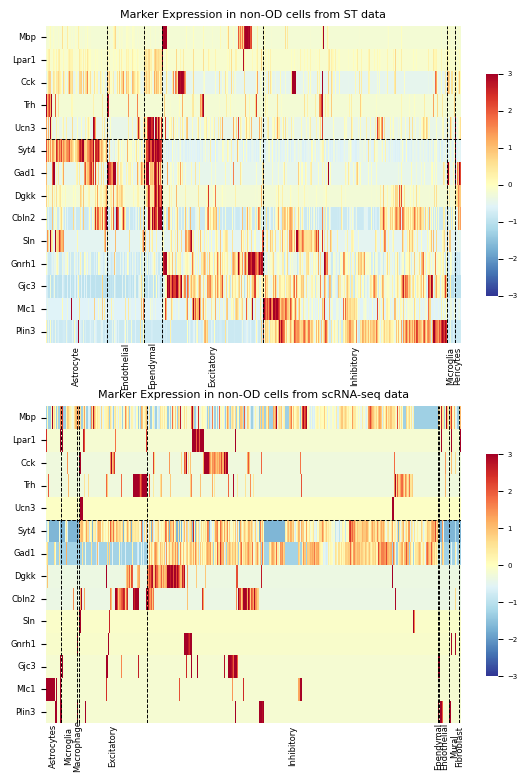

In [74]:
fig, ax = plt.subplots(2, 1, figsize=(17*CM, 23*CM), sharey=True)

plot_annotate_heatmap(cluster_data=no_OD_merfish_DE.T, cluster_labels=no_OD_cell_class, 
                      gene_groups=Gene_Group, cluster_text_y=15, ax=ax[0],
                      title="Marker Expression in non-OD cells from ST data")
plot_annotate_heatmap(cluster_data = noOD_sc_data, cluster_labels=noOD_sc_cell_class, 
                      gene_groups=Gene_Group, cluster_text_y=15, ax=ax[1],
                      title="Marker Expression in non-OD cells from scRNA-seq data")

plt.savefig(fig_path/"MarkernonMOD.pdf", **SAVE_FIG)
plt.show()